In [8]:

from FastCCM import CCM
import numpy as np
from sklearn.decomposition import PCA
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import get_truncated_lorenz_rand
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import importlib
from manifold_learning import imd_nd_smap
importlib.reload(imd_nd_smap)
importlib.reload(CCM)
importlib.reload(utils)

<module 'manifold_learning.utils.utils' from '/home/iaroslav/Documents/Python projects/manifold_learning/src/manifold_learning/utils/utils.py'>

In [9]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y,axis=1)**2 / (2 * sigma**2))

In [10]:
X = get_truncated_lorenz_rand(400,n_steps=20000)

In [20]:
exp_kernel_grid = np.array(np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),10), np.linspace(X[:,2].min(),X[:,2].max(),10))).reshape(2,-1).T

In [12]:
X_ = [get_truncated_lorenz_rand(400,n_steps=20000)[:,[0,2]] for i in range(5)]
observables = np.concatenate([np.array([gaussian_kernel(x,e,sigma=15) for e in exp_kernel_grid]) for x in X_]).T

observables = StandardScaler().fit_transform(observables)

In [21]:
X_ = [get_truncated_lorenz_rand(400,n_steps=20000)[:,[0,2]] for i in range(5)]
observables = np.concatenate([np.array([gaussian_kernel(x,e,sigma=6) for e in exp_kernel_grid]) for x in X_]).T
observables[observables < 0.1] = 0
mixing_mat = np.random.normal(size=(observables.shape[1],observables.shape[1]))
observables = observables @ mixing_mat
observables = StandardScaler().fit_transform(observables)

Epoch 1/1, Loss: 1.2199
Epoch 1/1, Loss: 1.2431
Epoch 1/1, Loss: 1.1758
Epoch 1/1, Loss: 1.0830
Epoch 1/1, Loss: 1.0207
Epoch 1/1, Loss: 0.9718
Epoch 1/1, Loss: 0.9531
Epoch 1/1, Loss: 0.9118
Epoch 1/1, Loss: 0.8897
Epoch 1/1, Loss: 0.8713
Epoch 1/1, Loss: 0.8623
Epoch 1/1, Loss: 0.8216
Epoch 1/1, Loss: 0.8067
Epoch 1/1, Loss: 0.7862
Epoch 1/1, Loss: 0.7814
Epoch 1/1, Loss: 0.7510
Epoch 1/1, Loss: 0.7436
Epoch 1/1, Loss: 0.7375
Epoch 1/1, Loss: 0.7197
Epoch 1/1, Loss: 0.7336
Epoch 1/1, Loss: 0.6959
Epoch 1/1, Loss: 0.7154
Epoch 1/1, Loss: 0.6859
Epoch 1/1, Loss: 0.6881
Epoch 1/1, Loss: 0.6512
Epoch 1/1, Loss: 0.6502
Epoch 1/1, Loss: 0.6552
Epoch 1/1, Loss: 0.6482
Epoch 1/1, Loss: 0.6311
Epoch 1/1, Loss: 0.6420
Epoch 1/1, Loss: 0.6266
Epoch 1/1, Loss: 0.6150
Epoch 1/1, Loss: 0.6086
Epoch 1/1, Loss: 0.6302
Epoch 1/1, Loss: 0.6272
Epoch 1/1, Loss: 0.6162
Epoch 1/1, Loss: 0.5908
Epoch 1/1, Loss: 0.6029
Epoch 1/1, Loss: 0.5918
Epoch 1/1, Loss: 0.5937
Epoch 1/1, Loss: 0.5749
Epoch 1/1, Loss:

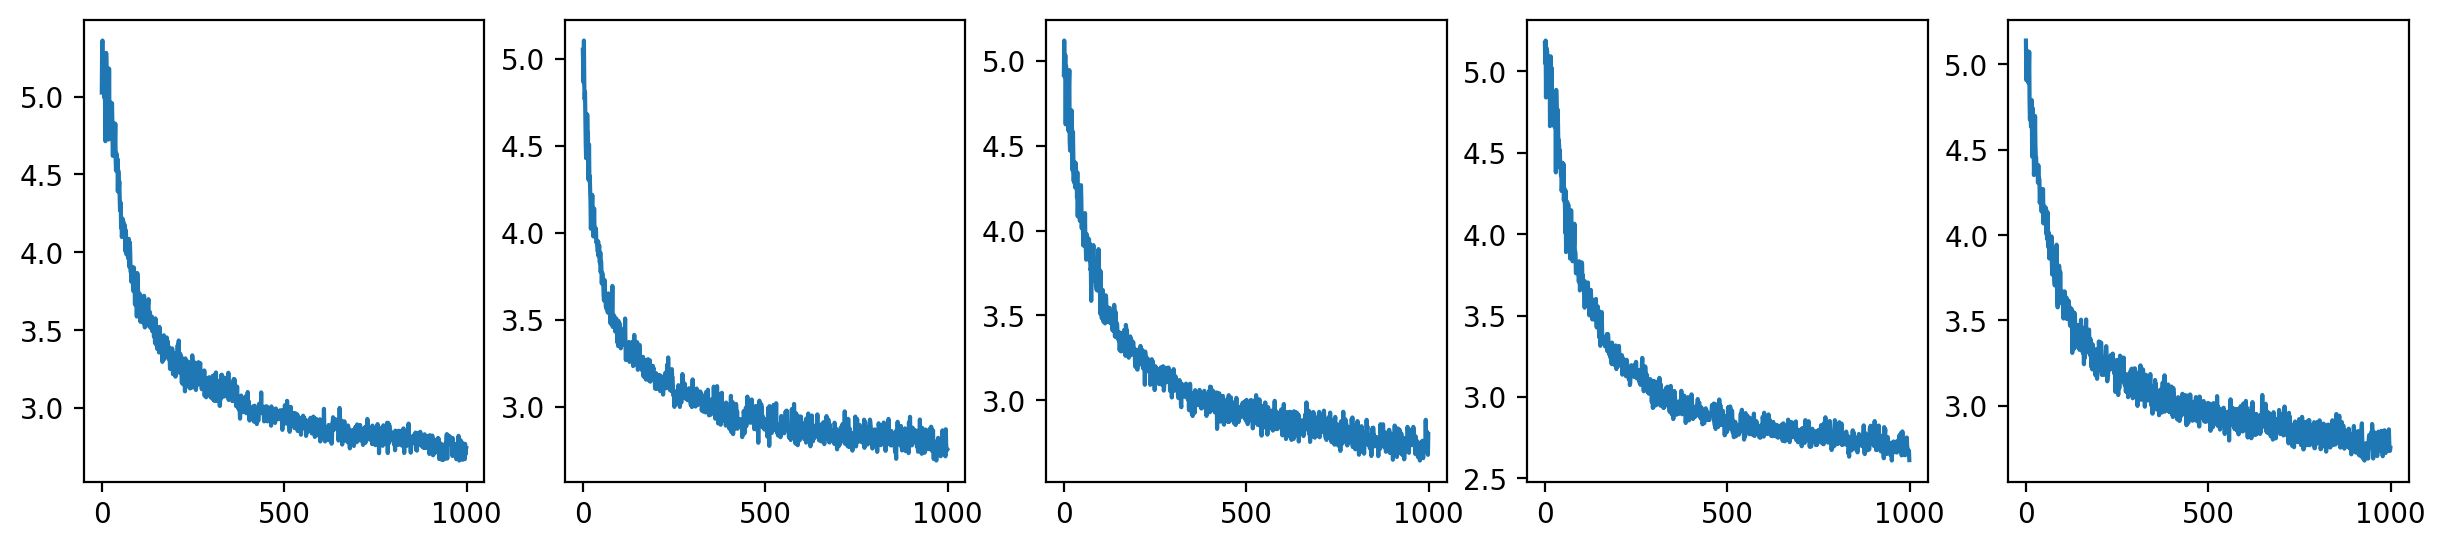

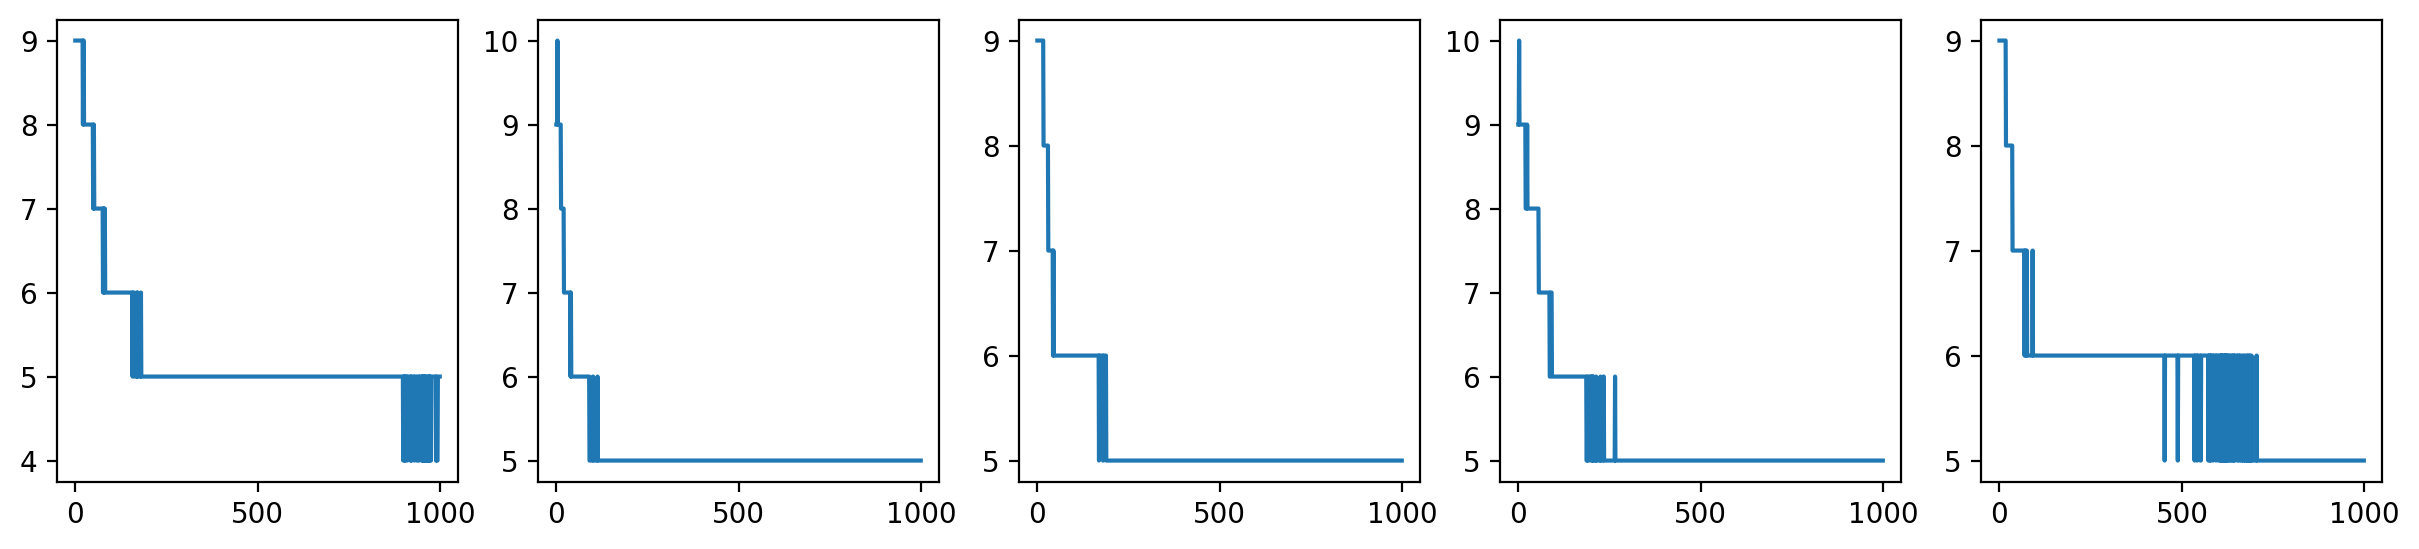

In [26]:
trainer = imd_nd_smap.IMD_nD_smap(observables.shape[1], embed_dim=10, n_components=5, subtract_corr=True, device="cuda")

corr_dims = []
ranks = []


for i in range(1000):
    trainer.fit(observables, sample_len=150, library_len=800, 
            exclusion_rad=100, theta=8, tp=30, 
            epochs=1, num_batches=32,optimizer="Adagrad", learning_rate=0.01, tp_policy="range",loss_mask_size=3)
    unmixed = trainer.predict(observables)
    corr_dims += [[utils.calculate_correlation_dimension(unmixed[np.random.randint(0,unmixed.shape[0],1000),i],device="cuda") for i in range(unmixed.shape[1])]]
    ranks += [[utils.calculate_rank_for_variance(unmixed[np.random.randint(0,unmixed.shape[0],5000),i],0.975) for i in range(unmixed.shape[1])]]
corr_dims = np.array(corr_dims)
ranks = np.array(ranks)

plt.figure(figsize=(3*unmixed.shape[1],3),dpi=200)
for i in range(unmixed.shape[1]):
    plt.subplot(1,unmixed.shape[1],i+1)
    plt.plot(corr_dims[:,i])

plt.figure(figsize=(3*unmixed.shape[1],3),dpi=200)
for i in range(unmixed.shape[1]):
    plt.subplot(1,unmixed.shape[1],i+1)
    plt.plot(ranks[:,i])

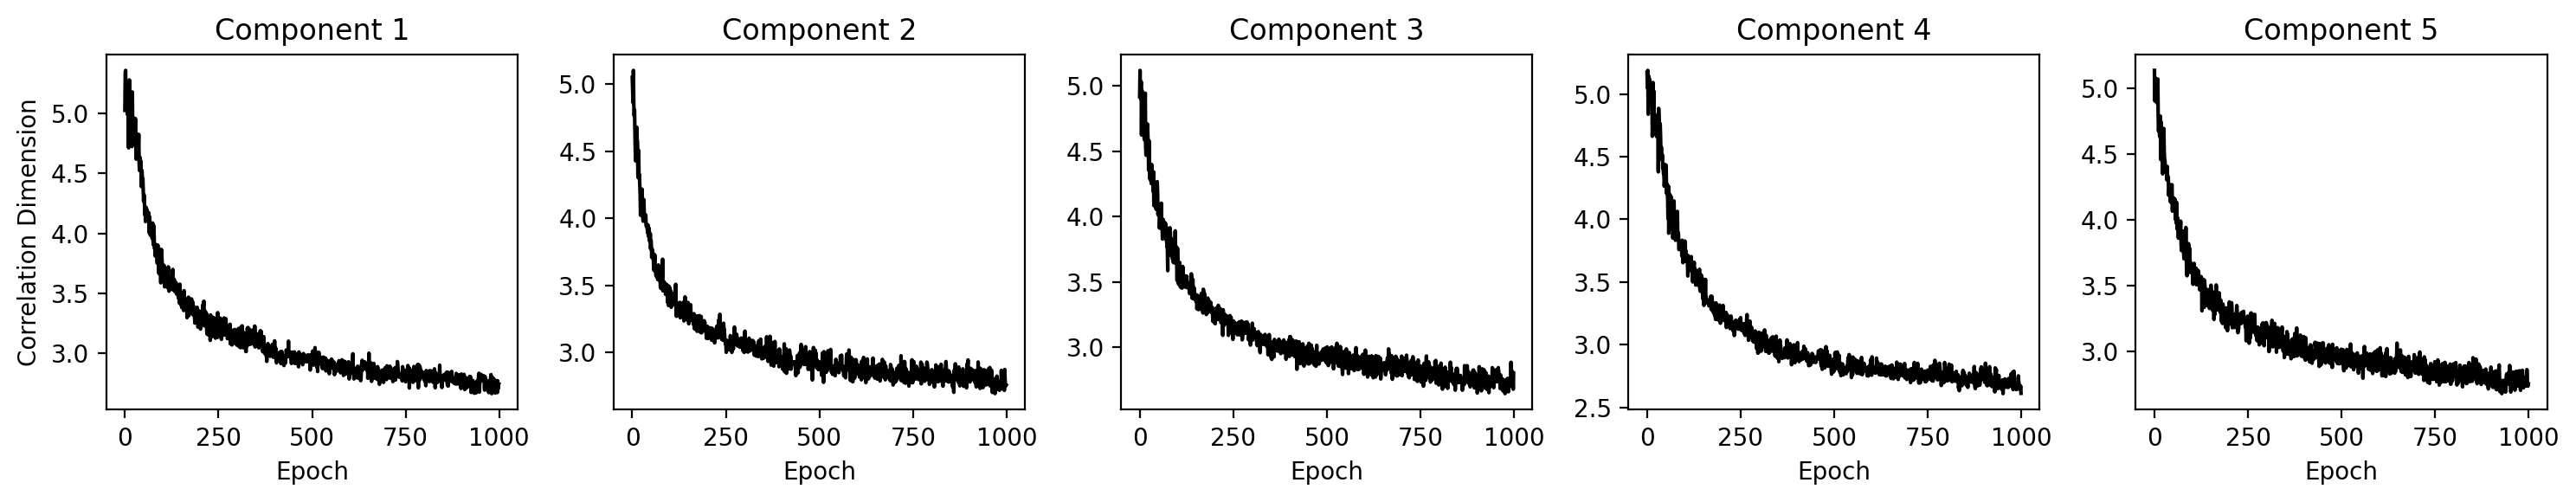

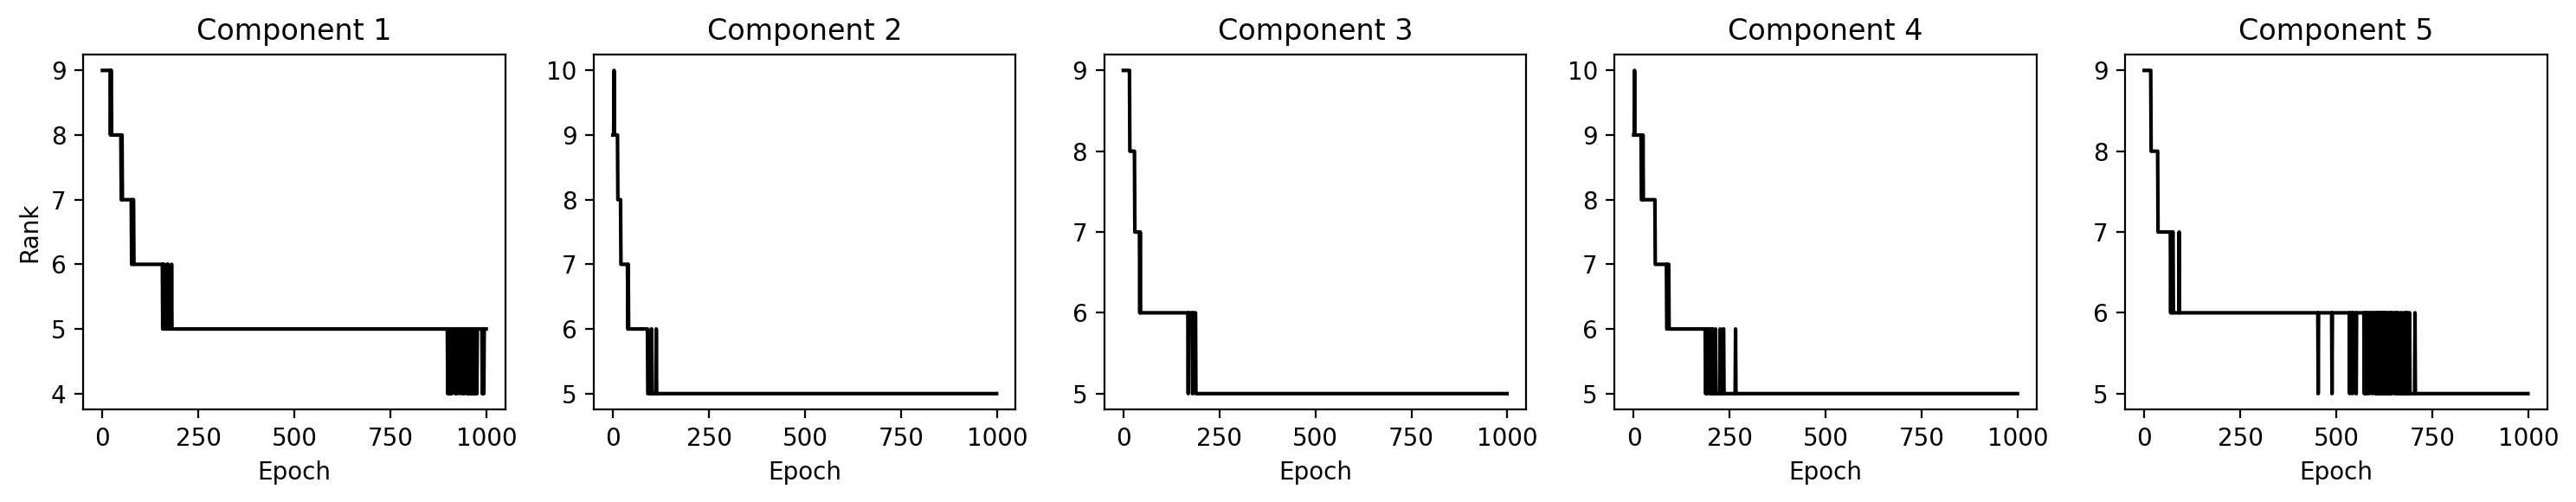

In [43]:
num_components = unmixed.shape[1]

# Create a figure with subplots for Correlation Dimension
fig1, axes1 = plt.subplots(1, num_components, figsize=(3*num_components, 3), dpi=200)

for i in range(num_components):
    axes1[i].plot(corr_dims[:, i],color="black")
    axes1[i].set_title(f"Component {i+1}")
    axes1[i].set_xlabel("Epoch")
    if i == 0:
        axes1[i].set_ylabel("Correlation Dimension")

fig1.tight_layout()
plt.show()

# Create a figure with subplots for Linear Independence Ranks
fig2, axes2 = plt.subplots(1, num_components, figsize=(3*num_components, 3), dpi=200)

for i in range(num_components):
    axes2[i].plot(ranks[:, i],color="black")
    axes2[i].set_title(f"Component {i+1}")
    axes2[i].set_xlabel("Epoch")
    if i == 0:
        axes2[i].set_ylabel("Rank")

fig2.tight_layout()
plt.show()

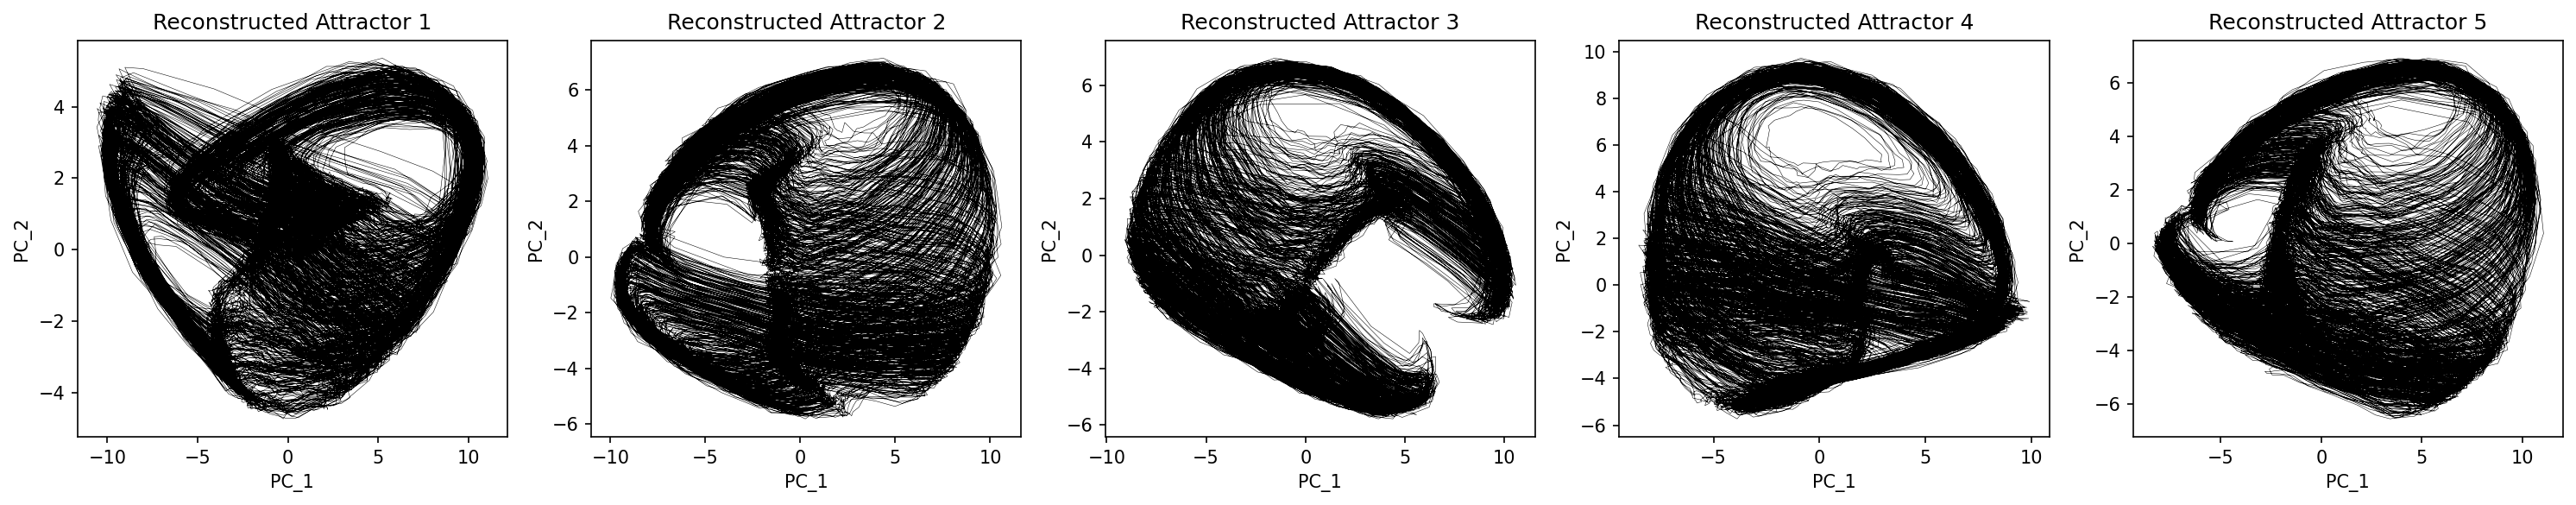

In [44]:
# Assuming 'unmixed' is your data array with shape (n_samples, n_systems, 2)
plt.figure(figsize=(4 * unmixed.shape[1], 4),dpi=150)

for i in range(unmixed.shape[1]):
    plt.subplot(1, unmixed.shape[1], i + 1)
    x_pca = PCA(2).fit_transform(unmixed[:,i,:])
    plt.plot(x_pca[:,0],x_pca[:,1],linewidth=0.25,color="black")
    plt.title(f"Reconstructed Attractor {i + 1}")
    plt.xlabel('PC_1')
    plt.ylabel('PC_2')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Loss')

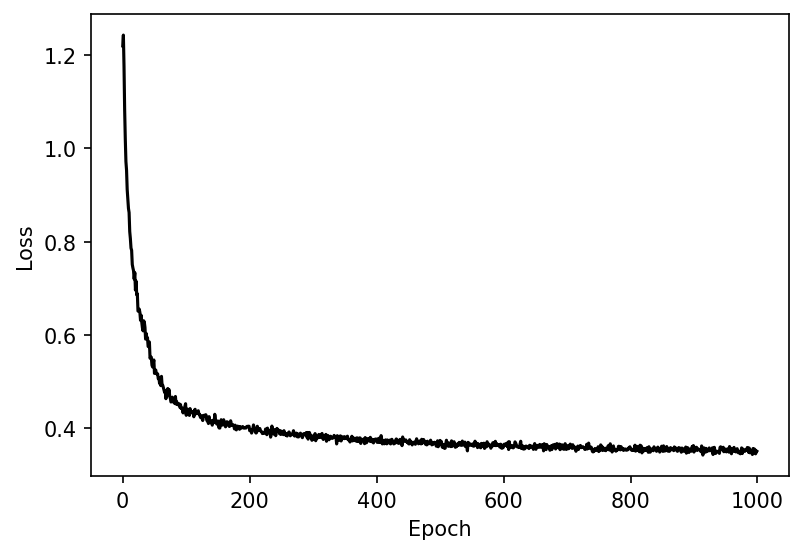

In [47]:
plt.figure(figsize=(6,4),dpi=150)
plt.plot(trainer.get_loss_history()[:],color="black")
plt.xlabel("Epoch")
plt.ylabel("Loss")


Text(0, 0.5, 'Ground truth')

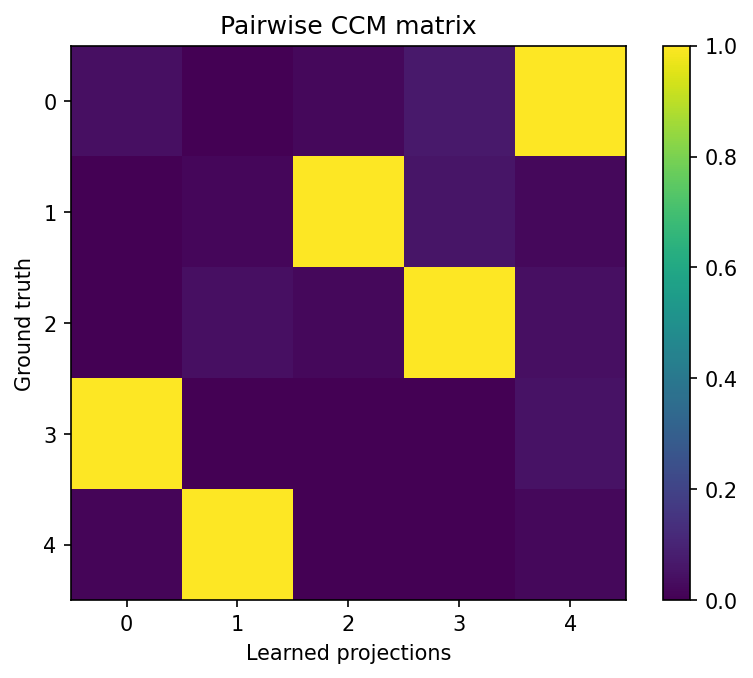

In [45]:
ccm_matrix_unmixed = CCM.PairwiseCCM().compute(
    np.transpose(unmixed, axes=(1, 0, 2)),
    X_,
    1500, 400, 60, 0,
    method="simplex",
    nbrs_num=15,
).mean(axis=0)
plt.figure(dpi=150)
plt.imshow(ccm_matrix_unmixed, vmin=0, vmax=1)
plt.colorbar()
plt.title("Pairwise CCM matrix")
plt.xlabel("Learned projections")
plt.ylabel("Ground truth")